Here we will train the architecture over the original dataset (grayscale MNIST). We want to make sure the encoder + classifier is able to detect the evenness of the numbers, but remains simple enough.

In [1]:
#from __future__ import annotations
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss, Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

from data import BinaryColoredMNIST, BiasedCifar10, BiasedBinaryMNIST, BiasedDataset

from models import MLPEncoder, ConvEncoder, ConvEncoderCIFAR, Classifier, Adversary

from train import Trainer

from predict import Predictor

from experiments import run_experiments, create_datasets
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(device)

cpu


In [4]:
def generate_p_y_a(bias, C, K, device):
    if bias >= 1.0:
        raise ValueError("bias has to be in the interval [0, 1)")
        
    p_y_a = torch.zeros(C, K)

    dominant_classes = torch.randperm(C)[:K]

    for j in range(K):
        
        uniform = torch.full((C,), 1.0 / C, device=device)
        
        one_hot = torch.zeros(C, device=device)
        one_hot[dominant_classes[j].item()] = 1.0
        
        p_y_a[:, j] = (1 - bias) * uniform + bias * one_hot

    return p_y_a

In [ ]:
C = 10
K = 10
bias = 0.999
dataset_name = 'CIFAR10'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = (
        create_datasets(C, K, bias=bias, dataset_name=dataset_name)
    )

In [13]:
generate_p_y_a(0.5, C, K, device)

tensor([[0.0500, 0.0500, 0.0500, 0.5500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.5500,
         0.0500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.5500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.5500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.0500, 0.5500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.5500, 0.0500,
         0.0500],
        [0.5500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.5500, 0.0500, 0.0500, 0.0500,
         0.0500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.5500],
        [0.0500, 0.0500, 0.0500, 0.0500, 0.5500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500]])

In [6]:
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

In [7]:
learning_rate = 1e-3
n_epochs = 10
latent_dim = 24

if dataset_name == "MNIST":
    encoder = MLPEncoder(latent_dim).to(device)
    #encoder = ConvEncoder(in_channels=1)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)

In [8]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 0.496841
Epoch 2 complete: Loss = 0.334223
Epoch 3 complete: Loss = 0.259321
Epoch 4 complete: Loss = 0.191138
Epoch 5 complete: Loss = 0.156711
Epoch 6 complete: Loss = 0.123345
Epoch 7 complete: Loss = 0.110758
Epoch 8 complete: Loss = 0.090198
Epoch 9 complete: Loss = 0.070316
Epoch 10 complete: Loss = 0.071210


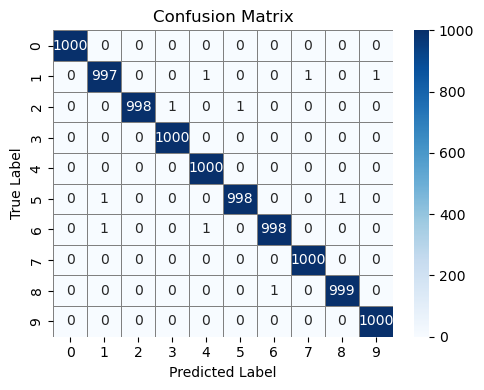

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000
           3       1.00      1.00      1.00      1000
           4       1.00      1.00      1.00      1000
           5       1.00      1.00      1.00      1000
           6       1.00      1.00      1.00      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [9]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

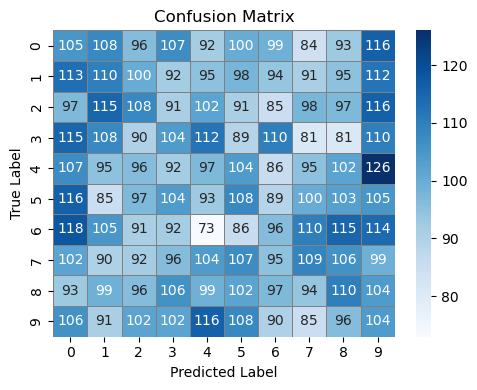

              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.11      0.11      0.11      1000
           2       0.11      0.11      0.11      1000
           3       0.11      0.10      0.10      1000
           4       0.10      0.10      0.10      1000
           5       0.11      0.11      0.11      1000
           6       0.10      0.10      0.10      1000
           7       0.12      0.11      0.11      1000
           8       0.11      0.11      0.11      1000
           9       0.09      0.10      0.10      1000

    accuracy                           0.11     10000
   macro avg       0.11      0.11      0.11     10000
weighted avg       0.11      0.11      0.11     10000



In [10]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)